**FITPREDICTOR NEURAL NETWORK DIAGRAM**

Saving FitPredictor_Neural_Network_diagram.png to FitPredictor_Neural_Network_diagram.png


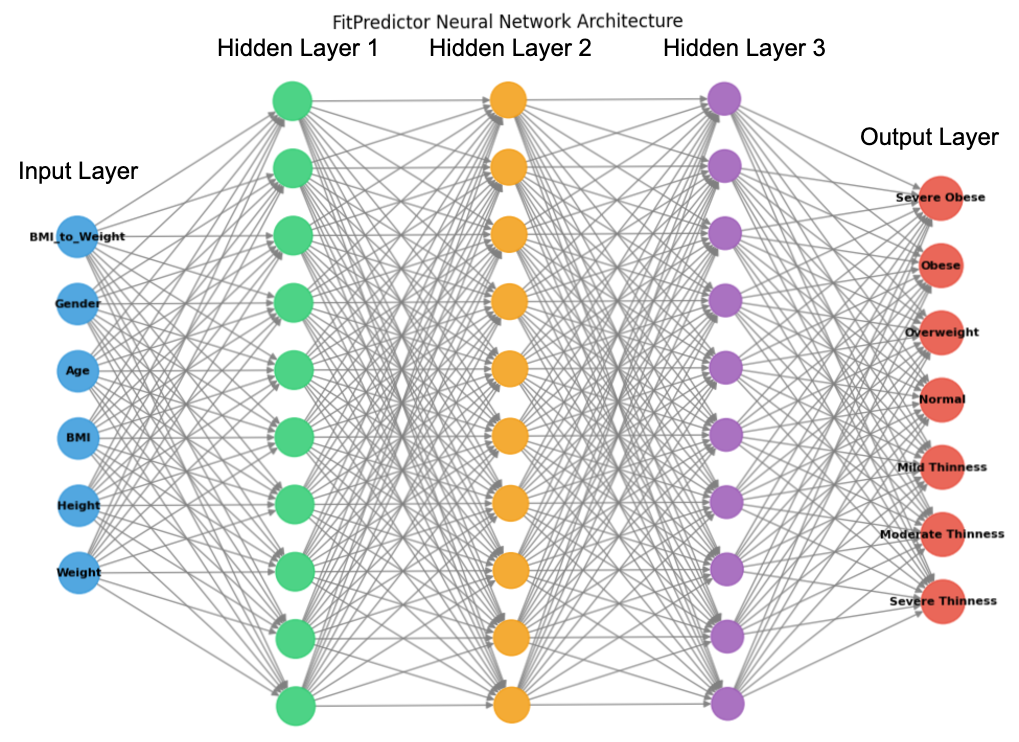

In [86]:
from google.colab import files

# Uploading the diagram
uploaded = files.upload()

from IPython.display import display, Image

# Displaying the diagram
display(Image("FitPredictor_Neural_Network_diagram.png"))



**IMPORTING LIBRARIES**

In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import os
import joblib
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model
print("All the required libraries have been imported!")

All the required libraries have been imported!


**DATASET LOADING**

In [88]:
data = pd.read_csv("/content/fitpredictor_dataset.csv")

# Displaying the first few rows
print("First 5 rows of the dataset:")
display(data.head())

# Show the number of rows & columns
print(f"\n Dataset shape: {data.shape}")


First 5 rows of the dataset:


,Weight,Height,BMI,Body Fat Percentage,BFPcase,Gender,Age,BMIcase,Exercise Recommendation Plan
0,76.811975,1.820521,23.175956,18.281148,Acceptable,Male,29,normal,4
1,77.721154,1.945498,20.534184,13.731021,Fitness,Male,23,normal,4
2,87.558726,1.742754,28.828859,42.304631,Obese,Female,57,over weight,5
3,89.473356,1.758318,28.940017,27.958021,Obese,Male,41,over weight,5
4,69.963943,1.722570,23.578732,16.464478,Fitness,Male,19,normal,4



 Dataset shape: (5000, 9)


**DATA PREPROCESSING & VISUALIZATION** & **CREATING A FOLDER**


 Checking for missing values:
Weight                          0
Height                          0
BMI                             0
Body Fat Percentage             0
BFPcase                         0
Gender                          0
Age                             0
BMIcase                         0
Exercise Recommendation Plan    0
dtype: int64

 THE HEATMAP:


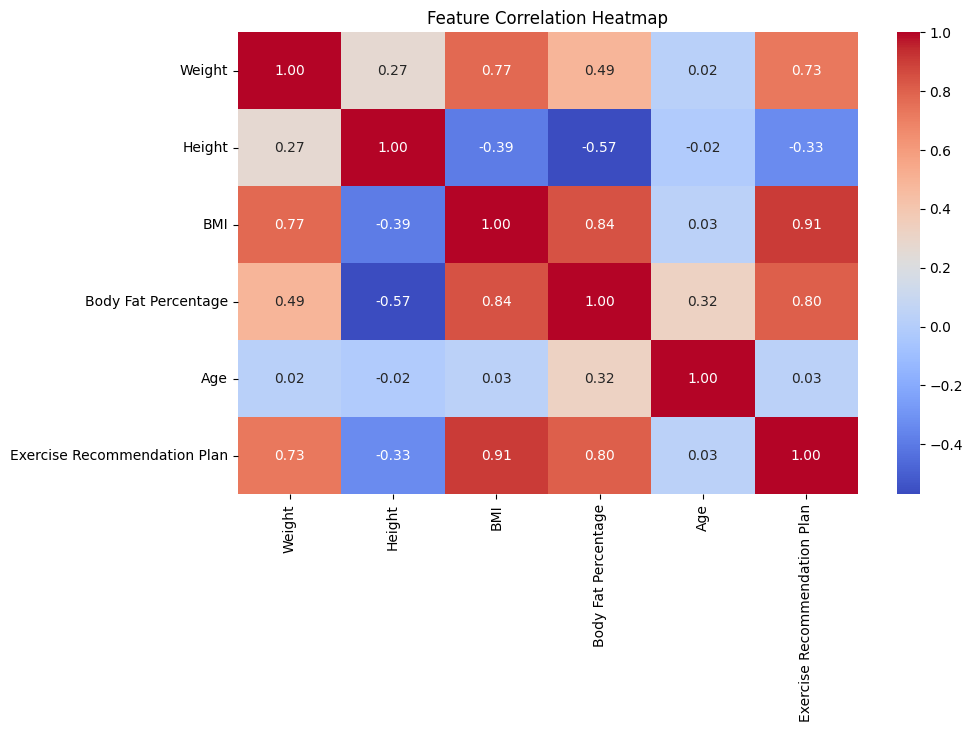

In [90]:
# Creating a directory
os.makedirs("/content/saved_models", exist_ok=True)

# Checking for missing values
print("\n Checking for missing values:")
print(data.isnull().sum())


# Heatmap
print("\n THE HEATMAP:")
plt.figure(figsize=(10,6))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


**FEATURE ENGINEERING**

In [91]:
# Drop highly correlated features
data.drop(columns=["Body Fat Percentage", "BFPcase", "Exercise Recommendation Plan"], inplace=True)

# Creating a new feature
data["BMI_to_Weight"] = data["BMI"] / data["Weight"]


# Standardizing numerical features
scaler = StandardScaler()
numerical_features = ["Weight", "Height", "BMI", "Age", "BMI_to_Weight"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])


# Save the StandardScaler
joblib.dump(scaler, "/content/saved_models/scaler.pkl")

# Encoding categorical features
label_encoders = {}
categorical_features = ["Gender", "BMIcase"]
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

# Saving the LabelEncoder
joblib.dump(label_encoders, "/content/saved_models/label_encoders.pkl")

# Splittig data into train (70%), validation (15%) & test (15%)
X = data.drop(columns=["BMIcase"])
y = data["BMIcase"]
y = tf.keras.utils.to_categorical(y)

#spliting train (70%) & temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
X, y, test_size=0.3, stratify=y.argmax(axis=1), random_state=42
)

# splitting temp (30%) into validation (15%) & test (15%)
X_val, X_test, y_val, y_test = train_test_split(
X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(axis=1), random_state=42
)

# Handling class imbalance with SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.argmax(axis=1))
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled)

**FUNCTION FOR MODEL TRAINING, SAVING, PREDICTING & COMPUTING THE EVALUATION METRICS**

In [92]:
def train_save_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, save_dir="/content/saved_models", callbacks=None):
    os.makedirs(save_dir, exist_ok=True)

    # Passing the callbacks parameter
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    model.save(os.path.join(save_dir, f"{model_name}.h5"))

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"\n{model_name} Results:")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")

    return history, y_pred_probs, y_pred_classes, y_true


**SGD + MOMENTUM OPTIMIZER**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4822 - loss: 1.4565 - val_accuracy: 0.8027 - val_loss: 0.7357
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6914 - loss: 0.8584 - val_accuracy: 0.8307 - val_loss: 0.5571
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7156 - loss: 0.7959 - val_accuracy: 0.7640 - val_loss: 0.6206
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7191 - loss: 0.7699 - val_accuracy: 0.8507 - val_loss: 0.4821
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7320 - loss: 0.7361 - val_accuracy: 0.8453 - val_loss: 0.4867
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7452 - loss: 0.7273 - val_accuracy: 0.8453 - val_loss: 0.4666
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7300 - loss: 0.7454 - val_accuracy: 0.7653 - val_loss: 0.6291
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7594 - loss: 0.6793 - val_accuracy: 0.793

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

sgd_momentum_model Results:
 Accuracy: 0.8467
 Precision: 0.8616
 Recall: 0.8467
 F1 Score: 0.8501


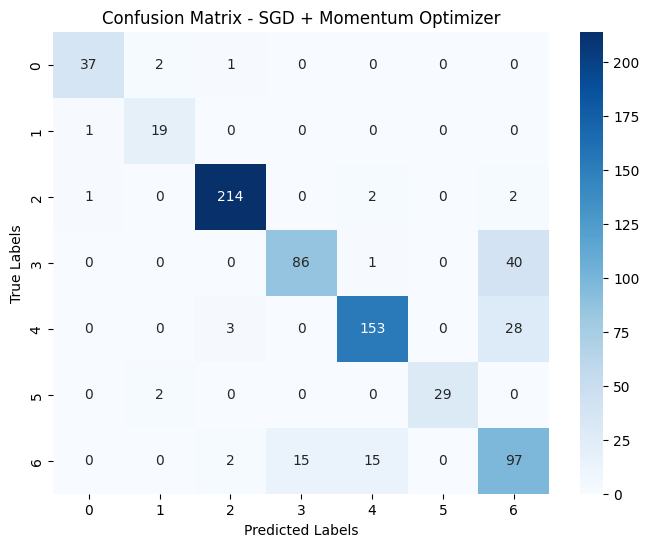

In [93]:
# Define EarlyStopping callback with a patience value of 20 epochs
early_stop_sgd = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Defining the Neural Network Model with SGD + Momentum Optimizer
sgd_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compiling the Model
sgd_model.compile(optimizer=SGD(learning_rate=0.005, momentum=0.95),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Training, saving & evaluating the model
history_sgd, y_pred_probs, y_pred_classes, y_true = train_save_evaluate(
    sgd_model, "sgd_momentum_model",
    X_train_resampled, y_train_resampled,
    X_val, y_val, X_test, y_test,
    callbacks=[early_stop_sgd]
)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SGD + Momentum Optimizer")
plt.show()

**Model evaluation and performance metrics**

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8467
Precision: 0.8616
Recall: 0.8467
F1 Score: 0.8501
ROC AUC: 0.9811
Confusion Matrix:
[[ 37   2   1   0   0   0   0]
 [  1  19   0   0   0   0   0]
 [  1   0 214   0   2   0   2]
 [  0   0   0  86   1   0  40]
 [  0   0   3   0 153   0  28]
 [  0   2   0   0   0  29   0]
 [  0   0   2  15  15   0  97]]


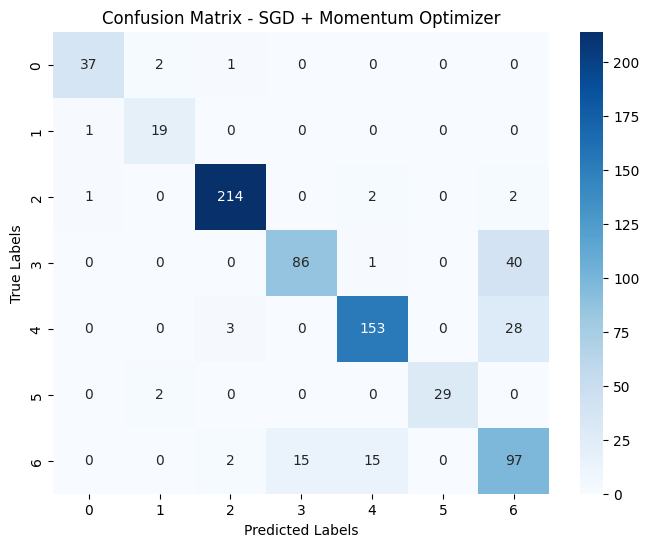

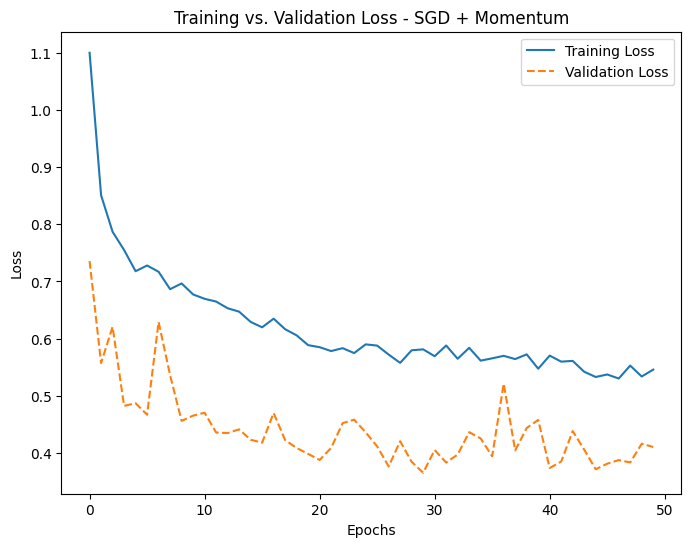

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
best_model_path = "/content/saved_models/sgd_momentum_model.h5"
model = load_model(best_model_path)
pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test, axis=1)

acc = accuracy_score(true_classes, pred_classes)
prec = precision_score(true_classes, pred_classes, average='weighted')
rec = recall_score(true_classes, pred_classes, average='weighted')
f1_val = f1_score(true_classes, pred_classes, average='weighted')
roc_auc = roc_auc_score(y_test, pred_probs, multi_class='ovr', average='weighted')

print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(prec))
print("Recall: {:.4f}".format(rec))
print("F1 Score: {:.4f}".format(f1_val))
print("ROC AUC: {:.4f}".format(roc_auc))

cm_matrix = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix:")
print(cm_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SGD + Momentum Optimizer")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history_sgd.history['loss'], label='Training Loss')
plt.plot(history_sgd.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss - SGD + Momentum")
plt.legend()
plt.show()


**Load & test the saved Model**


In [95]:
# Loading the saved sabedmodel
loaded_model = load_model("/content/saved_models/sgd_momentum_model.h5")

# Loading the saved StandardScaler
scaler = joblib.load("/content/saved_models/scaler.pkl")

# Loading the saved LabelEncoders
label_encoders = joblib.load("/content/saved_models/label_encoders.pkl")

# Selecting test examples
sample_input = X_test[:5]
predictions = loaded_model.predict(sample_input)

# Converting the predicted class indexes back to original labels
predicted_classes = np.argmax(predictions, axis=1)
decoded_classes = label_encoders["BMIcase"].inverse_transform(predicted_classes)

# Displaying results
for i, pred in enumerate(decoded_classes):
    print(f"Sample {i+1}: BMICase -> {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Sample 1: BMICase -> severe obese
Sample 2: BMICase -> severe obese
Sample 3: BMICase -> over weight
Sample 4: BMICase -> normal
Sample 5: BMICase -> normal
